importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score

from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support


In [ ]:
%%capture
! pip install -U sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/NLP_Bocconi/NLP_spoiler'
cl_rev = pd.read_json(f'{path}/data/reduced_cleaned_reviews.json')
cl_rev.head()

,movie_id,clean_text,is_spoiler,title
0,tt0105112,Patriot Games is a more than serviceable thril...,False,Patriot Games
1,tt0105112,I have read all of the Tom Clancy fiction book...,False,Patriot Games
2,tt0105112,When CIA analyst Jack Ryan Harrison Ford inter...,False,Patriot Games
3,tt0105112,Phillip Noyce is Patriot Games is a superb fil...,False,Patriot Games
4,tt0105112,Hello First I do not own a copy of the Patriot...,False,Patriot Games


# Clean the text

In [ ]:
cl_rev['clean_text'] = cl_rev['clean_text'].apply(lambda x: x.strip())

In [ ]:
len(cl_rev)

117216

In [ ]:
len(cl_rev.movie_id.unique())

1570

# T5 - Logistic

In [ ]:

X = cl_rev[['clean_text', 'is_spoiler']]
train, testing = train_test_split(X, test_size=0.2, random_state=42)
dev, test = train_test_split(testing, test_size=0.5, random_state=42)

In [ ]:
len(train), len(dev), len(test)

(93772, 11722, 11722)

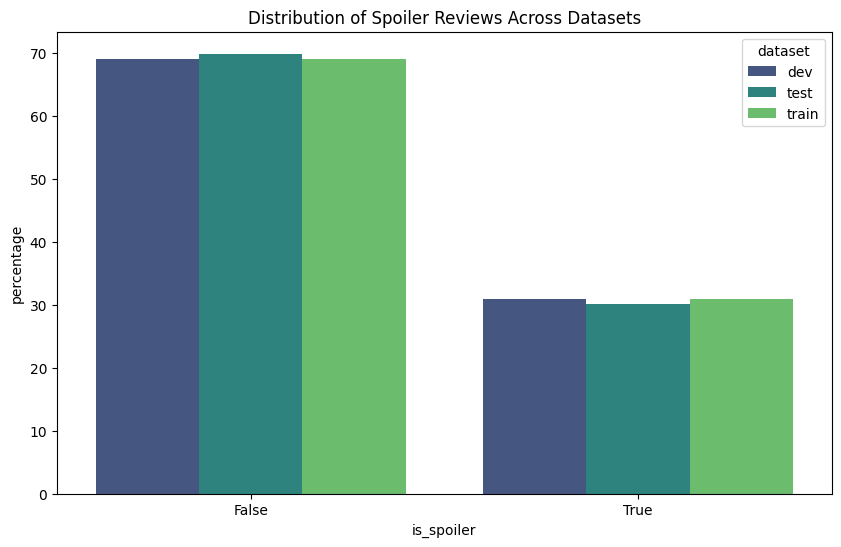

In [ ]:
train['dataset'] = 'train'
dev['dataset'] = 'dev'
test['dataset'] = 'test'

# Combine the dataframes
combined_data = pd.concat([train, dev, test])
# Calculate percentage
percentage_data = combined_data.groupby('dataset')['is_spoiler'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='is_spoiler', y='percentage', hue='dataset', data=percentage_data, palette='viridis')
plt.title('Distribution of Spoiler Reviews Across Datasets')
plt.show()

In [ ]:
train = pd.DataFrame(train).reset_index(drop=True)
dev = pd.DataFrame(dev).reset_index(drop=True)
test = pd.DataFrame(test).reset_index(drop=True)

## Embeddings

computes the t5 embeddings if not available otherwise it loads the existing ones

In [ ]:
from sentence_transformers import SentenceTransformer


def embed_text():

  if not os.path.exists(f'{path}/data/embedding_t5_titles.npy'):
    print('Start calculating embeddings...')
    model = SentenceTransformer('sentence-transformers/sentence-t5-base')

    print(f'... using {model}')
    embeddings = model.encode(train['clean_text'], show_progress_bar = True)
    val_embeddings = model.encode(dev['clean_text'], show_progress_bar = True)
    test_embeddings = model.encode(test['clean_text'], show_progress_bar = True)

    emb = np.concatenate((embeddings, val_embeddings, test_embeddings))
    np.save(f'{path}/data/embedding_t5_titles.npy',emb )
  else:
    print('Loading existing embeddings...')
    emb = np.load(f'{path}/data/embedding_t5_titles.npy')
    embeddings, val_embeddings, test_embeddings = emb[:len(train)], emb[len(train):len(train) + len(dev)], emb[len(train) + len(dev) : ]
  return embeddings, val_embeddings, test_embeddings

In [ ]:
embeddings, val_embeddings, test_embeddings = embed_text()

Loading existing embeddings...


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression(n_jobs=-1, random_state=42, max_iter = 5000,class_weight = 'balanced')#, C = 0.9)

cls.fit(embeddings, train['is_spoiler'])

train_predictions = cls.predict(embeddings)
print('Train performance:')
print(classification_report(train['is_spoiler'], train_predictions))

predictions = cls.predict(val_embeddings)

# performance report
print('Dev performance:')
print(classification_report(dev['is_spoiler'], predictions))
print(f1_score(dev['is_spoiler'], predictions, average='macro'))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Train performance:
              precision    recall  f1-score   support

       False       0.81      0.66      0.72     64810
        True       0.46      0.65      0.54     28962

    accuracy                           0.65     93772
   macro avg       0.63      0.65      0.63     93772
weighted avg       0.70      0.65      0.67     93772

Dev performance:
              precision    recall  f1-score   support

       False       0.80      0.66      0.73      8104
        True       0.46      0.64      0.53      3618

    accuracy                           0.66     11722
   macro avg       0.63      0.65      0.63     11722
weighted avg       0.70      0.66      0.67     11722

0.6302860054189776


In [ ]:
test_predictions = cls.predict(test_embeddings)

# performance report
print('Test performance:')
print(classification_report(test['is_spoiler'], test_predictions))
print(f1_score(test['is_spoiler'], test_predictions, average='macro'))

Test performance:
              precision    recall  f1-score   support

       False       0.81      0.66      0.73      8196
        True       0.45      0.65      0.53      3526

    accuracy                           0.66     11722
   macro avg       0.63      0.66      0.63     11722
weighted avg       0.71      0.66      0.67     11722

0.6314233753780691


# T5 - XGBoost

In [ ]:
%%capture
!pip install xgboost

In [ ]:
y_train = train['is_spoiler'].to_numpy()
y_dev = dev['is_spoiler'].to_numpy()
y_test = test['is_spoiler'].to_numpy()

import xgboost as xgb

cls = xgb.XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.1,
                        subsample=0.8, colsample_bytree=0.8, n_jobs=-1,
                        random_state=42, use_label_encoder=False, eval_metric='logloss', )

cls.fit(embeddings, y_train, eval_set=[(val_embeddings, y_dev)], early_stopping_rounds=10, verbose=False)


In [ ]:
# performance report on validation
predictions = cls.predict(val_embeddings)
print('Dev performance:')
print(classification_report(y_dev, predictions))
print(f1_score(y_dev, predictions, average='macro'))

# performance report on test
predictions = cls.predict(test_embeddings)
print('Test performance:')
print(classification_report(y_test, predictions))
print(f1_score(y_test, predictions, average='macro'))

Dev performance:
              precision    recall  f1-score   support

       False       0.73      0.93      0.82      8104
        True       0.62      0.24      0.34      3618

    accuracy                           0.72     11722
   macro avg       0.68      0.59      0.58     11722
weighted avg       0.70      0.72      0.67     11722

0.5825957257642667
Dev performance:
              precision    recall  f1-score   support

       False       0.74      0.93      0.83      8196
        True       0.60      0.23      0.34      3526

    accuracy                           0.72     11722
   macro avg       0.67      0.58      0.58     11722
weighted avg       0.70      0.72      0.68     11722

0.5814457873510236


# Distil-BERT

In [ ]:
%%capture
! pip install accelerate -U
!pip install --upgrade accelerate -U
! pip install transformers

In [ ]:
def get_tokens():
  if os.path.exists(f'{path}/data/reduced_encoded_texts.pt'):
    print('Loading existing encodings...')
    # Load the encoded texts
    encoded_texts = torch.load(f'{path}/data/reduced_encoded_texts.pt')
    print('Encodings loaded')
  else:
    print('Text tokenization begun...')
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    encoded_texts = tokenizer(cl_rev['clean_text'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
    print('Tokenization ended, now saving the encodings...')
    file_name = f'{path}/data/reduced_encoded_texts.pt'
    torch.save(encoded_texts, file_name)
    print(f'Encodings saved in {file_name}')
  return encoded_texts

encoded_texts = get_tokens()

Loading existing encodings...
Encodings loaded


In [ ]:
encoded_texts.items()

dict_items([('input_ids', tensor([[  101, 16419,  2399,  ...,     0,     0,     0],
        [  101,  1045,  2031,  ...,     0,     0,     0],
        [  101,  2043,  9915,  ...,     0,     0,     0],
        ...,
        [  101, 29467,  2003,  ...,     0,     0,     0],
        [  101,  2190,  2162,  ...,     0,     0,     0],
        [  101,  9543,  3406,  ...,     0,     0,     0]])), ('attention_mask', tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]))])

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype = torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
dataset = TextDataset(encoded_texts, cl_rev['is_spoiler'].tolist())
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, validation = random_split(dataset, [train_size, val_size], generator = generator1)
val_dataset, test_dataset = random_split(validation, [0.5, 0.5], generator = generator1)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

93772 11722 11722


In [ ]:
label2id = {'False':0, 'True':1}
id2label = {value: key for (key, value) in label2id.items()}

training_args = TrainingArguments(output_dir='./results', num_train_epochs=3,
                                  per_device_train_batch_size=16, per_device_eval_batch_size=16,
                                  weight_decay=0.01, gradient_accumulation_steps = 4)

device = torch.device(type='cuda') if torch.cuda.is_available() else torch.device(type='cpu')
print(f'Running on device {device}')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label2id))
model.to(device)


def compute_metrics(predictions_in):
    labels = predictions_in.label_ids
    predictions = predictions_in.predictions.argmax(-1)

    # Compute F1-score and recall
    macro_f1 = f1_score(y_true=labels, y_pred=predictions, average='macro')
    precision, recall, _, _ = precision_recall_fscore_support(y_true=labels, y_pred=predictions, average='macro')

    print(f'F1-score: {macro_f1}, Recall: {recall}')

    return {'macro_f1': macro_f1, 'recall': recall}

trainer = Trainer(model = model, args = training_args, train_dataset = train_dataset,
                  eval_dataset = val_dataset, compute_metrics = compute_metrics)

trainer.train()

Running on device cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.550800
1000,0.528200
1500,0.523500
2000,0.478400
2500,0.472500
3000,0.456600


Step,Training Loss
500,0.550800
1000,0.528200
1500,0.523500
2000,0.478400
2500,0.472500
3000,0.456600
3500,0.379600
4000,0.374100


TrainOutput(global_step=4395, training_loss=0.46134914359135026, metrics={'train_runtime': 3141.6929, 'train_samples_per_second': 89.543, 'train_steps_per_second': 1.399, 'total_flos': 3.725937015477043e+16, 'train_loss': 0.46134914359135026, 'epoch': 2.9994881419552977})

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1)
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model, val_loader)

# Calculate metrics
print(classification_report(true_labels, predictions))
print("Macro F1 Score:", f1_score(true_labels, predictions, average='macro'))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      8126
           1       0.58      0.50      0.53      3596

    accuracy                           0.73     11722
   macro avg       0.68      0.67      0.67     11722
weighted avg       0.72      0.73      0.73     11722

Macro F1 Score: 0.6734527932903174


In [ ]:
model.save_pretrained(f'{path}/data/distilbert_model')

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
loaded_model = AutoModelForSequenceClassification.from_pretrained(f'{path}/data/distilbert_model')
loaded_model.to(device)
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = loaded_model(**batch)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1)
        predictions.extend(pred.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(true_labels, predictions))
print("Macro F1 Score:", f1_score(true_labels, predictions, average='macro'))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      8188
           1       0.58      0.49      0.53      3534

    accuracy                           0.74     11722
   macro avg       0.69      0.67      0.68     11722
weighted avg       0.73      0.74      0.73     11722

Macro F1 Score: 0.6764221249463978


# Bidirectional GRU with TF

In [ ]:
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

In [ ]:
texts = cl_rev.clean_text
labels = cl_rev.is_spoiler

# Tokenization
max_vocab_size = 20000  # Maximum vocabulary size
max_sequence_length = 200  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Padding
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

# Model definition
embedding_dim = 300

model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),
    GRU(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

batch_size = 64
epochs = 10
# Compile and train the model
model.compile(optimizer = keras.optimizers.Adam(5e-5), loss='binary_crossentropy', metrics=[keras.metrics.F1Score(average = 'macro'),
                                                                                              tf.keras.metrics.Recall()])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, class_weight=class_weights_dict, callbacks = [early_stopping])

# Evaluate model performance
loss, f1, rec = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test f1: {np.round(f1,2)}, Test precision:{np.round(prec,2)},Test recall: {np.round(rec,2)}")


predictions = model.predict(X_test)
# Generate classification report
binary_predictions = (predictions >= 0.5).astype(int)
class_report = classification_report(y_test, binary_predictions)

print("\nClassification Report:")
print(class_report)

Epoch 1/10
1484/1484 [==============================] - 78s 48ms/step - loss: 0.6927 - f1_score: 0.4718 - recall_5: 0.5283 - val_loss: 0.6874 - val_f1_score: 0.4698 - val_recall_5: 0.4230
Epoch 2/10
1484/1484 [==============================] - 39s 26ms/step - loss: 0.6651 - f1_score: 0.4718 - recall_5: 0.5559 - val_loss: 0.6196 - val_f1_score: 0.4698 - val_recall_5: 0.5613
Epoch 3/10
1484/1484 [==============================] - 36s 24ms/step - loss: 0.5983 - f1_score: 0.4718 - recall_5: 0.6514 - val_loss: 0.6327 - val_f1_score: 0.4698 - val_recall_5: 0.6345
Epoch 4/10
1484/1484 [==============================] - 35s 24ms/step - loss: 0.5581 - f1_score: 0.4718 - recall_5: 0.7075 - val_loss: 0.6091 - val_f1_score: 0.4698 - val_recall_5: 0.5471
Epoch 5/10
1484/1484 [==============================] - 35s 24ms/step - loss: 0.5256 - f1_score: 0.4718 - recall_5: 0.7411 - val_loss: 0.6435 - val_f1_score: 0.4698 - val_recall_5: 0.5823
Epoch 6/10
367/367 [==============================] - 4s 11m

# GPT-rephrased reviews prediction

In [ ]:
gpt_reviews = pd.read_csv(f'{path}/data/openai_reviews_backup.csv').reset_index(drop = True)
gpt_reviews.head()

In [ ]:
original_revs = gpt_reviews[gpt_reviews.rephrased_review.isna()].review_text[:93]

In [ ]:
gpt_reviews.dropna(subset = 'rephrased_review', inplace = True)

In [ ]:
gpt_temp = pd.DataFrame(pd.concat([gpt_reviews['rephrased_review'], original_revs],  axis = 0), columns = ['reviews']).reset_index(drop = True)
gpt_temp.head()

,reviews
0,In the second film adaptation of a Tom Clancy ...
1,"""Last Vegas"" is a comedy featuring a star-stud..."
2,"""Wet Hot American Summer"" is a film that defie..."
3,John Huston's talent as a director shines thro...
4,"In this sharp and witty high school comedy, a ..."


In [ ]:
labels = np.ones(186, dtype = bool)
labels[:93] = 0
gpt_temp['is_spoiler'] = labels

In [ ]:
gpt_temp

,reviews,is_spoiler
0,In the second film adaptation of a Tom Clancy ...,False
1,"""Last Vegas"" is a comedy featuring a star-stud...",False
2,"""Wet Hot American Summer"" is a film that defie...",False
3,John Huston's talent as a director shines thro...,False
4,"In this sharp and witty high school comedy, a ...",False
...,...,...
181,**Warning! Mild Spoilers Ahead!!**The premise ...,True
182,'The Pianist' is definitively an inspiring epi...,True
183,Stand By Me is without a doubt one of the fine...,True
184,Minor SpoilersPredator 2 is a great sequel.The...,True


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encoded_gpt = tokenizer(gpt_temp['reviews'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype = torch.long)
        return item

    def __len__(self):
        return len(self.labels)

gpt_dataset = TextDataset(encoded_gpt, gpt_temp['is_spoiler'].tolist())
gpt_loader = DataLoader(gpt_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device(type='cuda') if torch.cuda.is_available() else torch.device(type='cpu')

loaded_model = AutoModelForSequenceClassification.from_pretrained(f'{path}/distilbert_model')
loaded_model.to(device)
predictions, true_labels = [], []

with torch.no_grad():
    for batch in gpt_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = loaded_model(**batch)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1)
        predictions.extend(pred.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(true_labels, predictions))
print("Macro F1 Score:", f1_score(true_labels, predictions, average='macro'))

              precision    recall  f1-score   support

           0       0.61      0.78      0.69        93
           1       0.70      0.51      0.59        93

    accuracy                           0.65       186
   macro avg       0.66      0.65      0.64       186
weighted avg       0.66      0.65      0.64       186

Macro F1 Score: 0.6380896226415094
